## Cardiac Regulatory Network for CMRG
### CRNC developed by Shulin Cao
### Only for use in CMRG

In [82]:
###------Network Simulator------###
###------Shulin Cao------###
###------CMRG, UC San Diego------###

###import packages###
import pandas as pd
import collections
import timeit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics
import random
import numpy.linalg
import numpy as np
import sys
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()
from sklearn.linear_model import LinearRegression
from sklearn import cluster
import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.metrics import r2_score
import csv

In [83]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]

In [84]:
def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    
    if reactor[0] == '!':
        return (1-B*globals()['{}'.format(reactor[1:])]**n/(C**n + globals()['{}'.format(reactor[1:])]**n))
    else:
        return B*globals()['{}'.format(reactor)]**n/(C**n + globals()['{}'.format(reactor)]**n)

In [85]:
# def Ficks(c, x, D):
    # Assuming c and x are numpy arrays of equal size and D is a scalar
 #   deltaC = np.diff(c)
 #   deltaX = np.diff(x)

 #  return -D * deltaC / deltaX

In [86]:
def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [87]:
def inte(state,t,reaction_dict):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(len(node_ID)):
        if len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        #print(str(i)+' finished')
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [88]:
def hill_simulation( t, state0, reaction_dict):
    yHill_ss = odeint(inte, state0, t, args = (reaction_dict,))
    print('Hill Finished')
    return yHill_ss

In [100]:
inhibition = '/Users/mihir/Documents/Summer/Models/macrophage_model.xlsx'
no_inhibition = '/Users/mihir/Documents/Summer/Models/macrophage_model_no_inhibition.xlsx'

active = no_inhibition

In [101]:
###################-------------------------------###################
###################----------Loading Data---------###################
###################-------------------------------###################

reactions = pd.read_excel(active, sheet_name = 1, skiprows = 1, header = 0)
species = pd.read_excel(active, sheet_name = 0, skiprows = 1, header = 0)
pmid = reactions['PMID'].tolist()
reactions = reactions[['Rule', 'Weight', 'n', 'EC50']]
species = species[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
Ymax2 = species['Ymax'].tolist()
tau = species['tau'].tolist()

reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'Rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'Rule']] = reactions.loc[k, ['Weight', 'n', 'EC50']].tolist()


species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()


y0_MA = []
y30m_MA = []
y30m_MA_trans = []
y4h_MA = []
y4h_MA_trans = []
for i in range(len(node_ID)):
    y0_MA.append(Yinit[i])
    y30m_MA.append(Yinit[i])
    y30m_MA_trans.append(Yinit[i])
    y4h_MA.append(Yinit[i])
    y4h_MA_trans.append(Yinit[i])

In [102]:
geneinput = {i:0 for i in node_ID[98:]}

In [103]:
for j in node_ID[98:]:
    for k in reaction_dict[j]:
        if '!' in k:
            geneinput[j] = 0.5
            break

### Step 1 Finalize the baseline

In [104]:
state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])  #solve_ivp

t = np.arange(0.0, 80, 0.01)
yHill_ss = hill_simulation(t, state0, reaction_dict)

Hill Finished


### Basic Plots

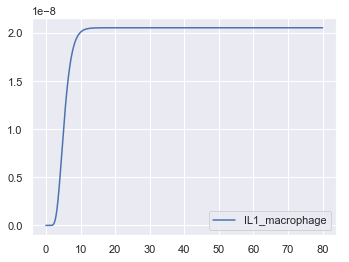

In [105]:
k=10000
plt.figure(figsize=(12,4))
plt.subplot(122)
plt.plot(t[:k], yHill_ss[:k,14], label = node_ID[14])
plt.legend(loc='best')
plt.show()

### Export Data to CSV

In [ ]:
print(t[:k])